In [1]:
# default_exp utils

In [2]:
#hide
#all_ignoretest
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#hide
!pip install fastai -Uqq
!pip3 install nbdev -q
!pip install einops -q

     |████████████████████████████████| 186 kB 28.3 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 51 kB 309 kB/s 


In [9]:
#hide
%cd '/content/drive/MyDrive/colab_notebooks/ckdhm'
!pip3 install -e . -q

/content/drive/MyDrive/colab_notebooks/ckdhm


In [5]:
#exporti
import seaborn as sns
from fastai.tabular.all import *
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix

In [10]:
#hide
from nbdev import * 
from nbdev.showdoc import *
from fastcore.test import *
from ckdhm.utils import get_features

ImportError: ignored

# SAINT TabModel
> In this notebook, we will call upon SAINT's help

## What is SAINT?

So far we have struggled to improve on our accuracy of 70-75%. One of the issue is the small nature of our dataset. Let's see if SAINT, an approach published not long ago, can help us.

SAINT is a new deep learning approach to solve tabular data problems. It uses/introduces the following

1. transformer/attetion architecture for tabular task
2. self-attention (row-wise attention) as well as intersample attention (across rows) attention
3. pre-training for tabular data using contrastive task
4. uses embeddinng for both categorical and continuous features

Below is the abstract from the [SAINT](https://arxiv.org/abs/2106.01342) paper.


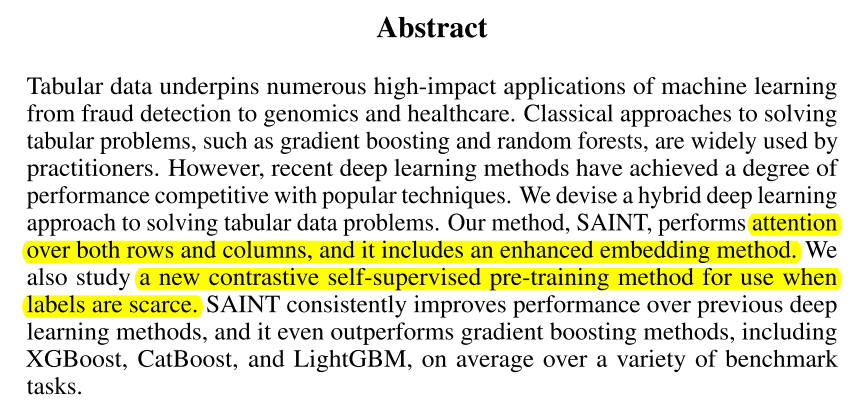

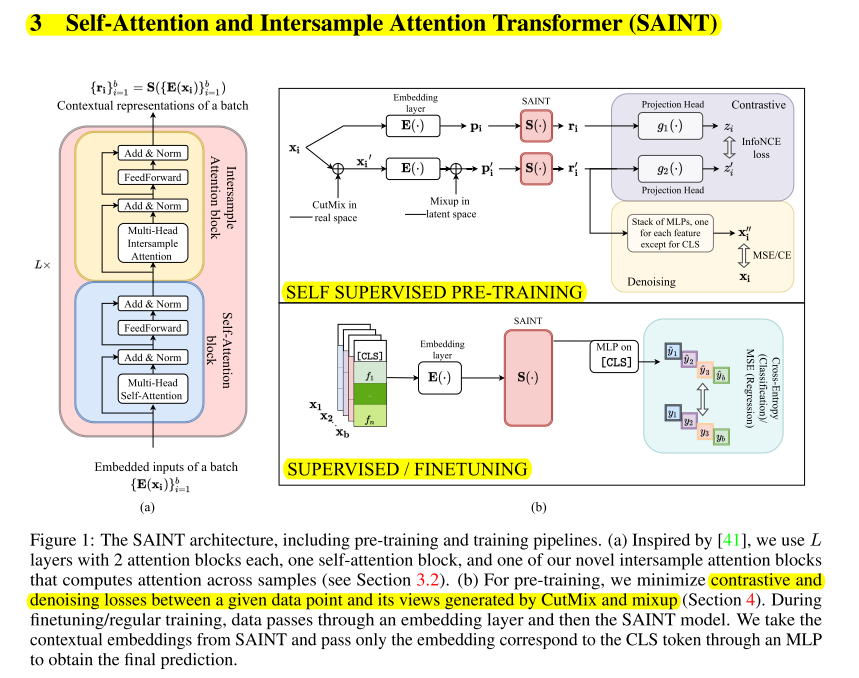

**SAINT Architecture**
* To cat features, a `[CLS]` token is appended whose embedding matrix will be later used for classification task
* Both continuous and categorical features are put through embeddinng layer to gather the embeadding matric of all features.
* The embeddings are then put through the transformer
      - each transformer is composed of single self-attention transformer block and single intersample-attention transformer block
      - the self-attention block uses multi-head attention followed by two fully-connected feed-forward layers with GELU non-linearity, skip connection and layer normalization
      - the intersample-attention is similar except it uses intersample-attention       


**Pre-Training**
* like in vision, this paper also introduces contrastive learning as pretraining for tabular data
* For augmentation, it uses cutmix (adding noise) in the raw space and mixup in the embedding matrix space to generate two-views
* the two views are then put through SAINT
* the output from SAINT is put through projection heads before contrastive loss is applied
* additionally the framework also provides possibility of adding a denoising task where MLPs are used to reduce the noise between the two views




In [ ]:
#exporti
#codes from the paper -- https://github.com/somepago/saint/blob/a55fc0ca7ee0a35cf2b88fb692f48a31034b33ef/augmentations.py

def embed_data_mask(x_categ, x_cont, cat_mask, con_mask, model):

    device = x_cont.device
    x_categ = x_categ + model.categories_offset.type_as(x_categ)
    x_categ_enc = model.embeds(x_categ)

    n1,n2 = x_cont.shape
    _, n3 = x_categ.shape

    if model.cont_embeddings == 'MLP':
        x_cont_enc = torch.empty(n1,n2, model.dim)
        for i in range(model.num_continuous):
            x_cont_enc[:,i,:] = model.simple_MLP[i](x_cont[:,i])
    else:
        raise Exception('This case should not work!')    


    x_cont_enc = x_cont_enc.to(device)
    cat_mask_temp = cat_mask + model.cat_mask_offset.type_as(cat_mask)
    con_mask_temp = con_mask + model.con_mask_offset.type_as(con_mask)


    cat_mask_temp = model.mask_embeds_cat(cat_mask_temp)
    con_mask_temp = model.mask_embeds_cont(con_mask_temp)
    x_categ_enc[cat_mask == 0] = cat_mask_temp[cat_mask == 0]
    x_cont_enc[con_mask == 0] = con_mask_temp[con_mask == 0]

    return x_categ, x_categ_enc, x_cont_enc


def mixup_data(x1, x2 , lam=1.0, y= None, use_cuda=True):
    '''Returns mixed inputs, pairs of targets'''

    batch_size = x1.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)


    mixed_x1 = lam * x1 + (1 - lam) * x1[index, :]
    mixed_x2 = lam * x2 + (1 - lam) * x2[index, :]
    if y is not None:
        y_a, y_b = y, y[index]
        return mixed_x1, mixed_x2, y_a, y_b
    
    return mixed_x1, mixed_x2


def add_noise(x_categ,x_cont, noise_params = {'noise_type' : ['cutmix'],'lambda' : 0.1}):
    lam = noise_params['lambda']
    device = x_categ.device
    batch_size = x_categ.size()[0]

    if 'cutmix' in noise_params['noise_type']:
        index = torch.randperm(batch_size)
        cat_corr = torch.from_numpy(np.random.choice(2,(x_categ.shape),p=[lam,1-lam])).to(device)
        con_corr = torch.from_numpy(np.random.choice(2,(x_cont.shape),p=[lam,1-lam])).to(device)
        x1, x2 =  x_categ[index,:], x_cont[index,:]
        x_categ_corr, x_cont_corr = x_categ.clone().detach() ,x_cont.clone().detach()
        x_categ_corr[cat_corr==0] = x1[cat_corr==0]
        x_cont_corr[con_corr==0] = x2[con_corr==0]
        return x_categ_corr, x_cont_corr
    elif noise_params['noise_type'] == 'gauss':
        print("yet to write this")

#helper functions
def data_prep(data, prob):
    'given a batch of data from fastai dataloader prepares the necessary input'
    if prob == '3pt':  
        x_categ = data[0]
        x_cont = data[1]
        y = data[2]
        x_categ = torch.cat([x_categ, y], 1)

        cat_mask = np.ones_like(np.empty((x_categ.shape[0], (x_categ.shape[1]))))
        cat_mask[...,-1] = 0

        con_mask = np.ones_like(np.empty((x_cont.shape[0], (x_cont.shape[1]))))

        cat_mask = tensor(cat_mask).int()
        con_mask = tensor(con_mask).int()

    elif prob == 'fnp':
        x_categ = data[0]
        x_cont = data[1]
        y = data[2]
        x_categ = torch.cat([x_categ, y], 1)
        x_cont.nan_to_num_(0.)

        cat_mask = np.ones_like(np.empty((x_categ.shape[0], (x_categ.shape[1]))))
        cat_mask[...,-1] = 0

        con_mask = torch.where(x_cont==0., 0, 1)

        cat_mask = tensor(cat_mask).int()
        con_mask = tensor(con_mask).int()

    return x_categ, x_cont, cat_mask, con_mask


def data_prep_fnp(data):
    'given a batch of data from fastai dataloader prepares the necessary input'



    return x_categ, x_cont, cat_mask, con_mask


def pt_contrastive(x_categ_enc, x_cont_enc, 
                   x_categ_enc_2, x_cont_enc_2, 
                   pt_projecthead_style='diff',
                   tmp=0.5):

    'given two sets of categ and cont encodings, builds the contrastive task'

    aug_features_1  = model.transformer(x_categ_enc, x_cont_enc)
    aug_features_2 = model.transformer(x_categ_enc_2, x_cont_enc_2)
    aug_features_1 = (aug_features_1 / aug_features_1.norm(dim=-1, keepdim=True)).flatten(1,2)
    aug_features_2 = (aug_features_2 / aug_features_2.norm(dim=-1, keepdim=True)).flatten(1,2)

    if pt_projecthead_style == 'diff':
        aug_features_1 = model.pt_mlp(aug_features_1)
        aug_features_2 = model.pt_mlp2(aug_features_2)
    elif pt_projecthead_style == 'same':
        aug_features_1 = model.pt_mlp(aug_features_1)
        aug_features_2 = model.pt_mlp(aug_features_2)
    else:
        print('Not using projection head')

    logits_per_aug1 = aug_features_1 @ aug_features_2.t()/config['nce_temp']
    logits_per_aug2 =  aug_features_2 @ aug_features_1.t()/config['nce_temp']
    targets = torch.arange(logits_per_aug1.size(0)).to(logits_per_aug1.device)

    return logits_per_aug1, logits_per_aug2, targets


def get_saint_model(config, 
                    cat_dims, 
                    num_continuous, 
                    continuous_mean_std, 
                    y_sim):
  
    return SAINT(categories = tuple(cat_dims), 
                num_continuous = num_continuous,                
                dim = config['embedding_size'],                           
                dim_out = 1,                       
                depth = config['transformer_depth'],                       
                heads = config['attention_heads'],                         
                attn_dropout = config['attention_dropout'],             
                ff_dropout = config['ff_dropout'],                  
                mlp_hidden_mults = (4, 2),       
                continuous_mean_std = continuous_mean_std, 
                cont_embeddings = config['cont_embeddings'],
                attentiontype = config['attentiontype'],
                final_mlp_style = config['final_mlp_style'],
                y_dim = y_dim)


def get_saint_3pt_dls(fold, train_df, test_df, tp1, tp2, maxtimept, bs):
    features = get_features('data/dataScienceTask/')
    cat_names = ['race', 'gender']
    y_names = 'Stage_Progress'

    df, cont_names = prepare_df_ntimepoint(features, train_df, maxtimept, [tp1, tp2])
    test_df, cont_names = prepare_df_ntimepoint(features, test_df, maxtimept, [tp1, tp2])

    procs = [Categorify, FillMissing(add_col=False), Normalize]

    dls, tabdf = get_tabpandas_dls(fold, df, procs, cat_names, cont_names, y_names, bs)
    test_dl = dls.test_dl(test_df)
    y_dim = 2
    mean, std = list(dls.train.normalize.means.values()), list(dls.train.normalize.stds.values())
    continuous_mean_std = np.array([mean,std]).astype(np.float32) 

    categorical_dims = {o:len(i) for o,i in dls.train.categorify.classes.items()}
    cat_dims = list(categorical_dims.values())
    cat_dims.append(2)
    cat_dims = np.array(cat_dims).astype(int) 
    num_continuous = len(dls.cont_names)

    return dls, test_dl, tabdf, cat_dims, num_continuous, continuous_mean_std, y_dim

  
def get_saint_fnpt_dls(fold, train_df, test_df, n_tp, maxtimept, bs):
    features = get_features('data/dataScienceTask/')
    cat_names = ['race', 'gender']
    y_names = 'Stage_Progress'

    df, cont_names = prepare_df_firstnpt(features, train_df, n_tp, maxtimept)
    test_df, cont_names = prepare_df_firstnpt(features, test_df, n_tp, maxtimept)
    constants = {k:1000. for k in cont_names} 
    procs = [Categorify, Normalize] #, FillMissing(FillStrategy.constant, False, constants)]

    dls, tabdf = get_tabpandas_dls(fold, df, procs, cat_names, cont_names, y_names, bs)
    test_dl = dls.test_dl(test_df)
    y_dim = 2
    mean, std = list(dls.train.normalize.means.values()), list(dls.train.normalize.stds.values())
    continuous_mean_std = np.array([mean,std]).astype(np.float32) 

    categorical_dims = {o:len(i) for o,i in dls.train.categorify.classes.items()}
    cat_dims = list(categorical_dims.values())
    cat_dims.append(2)
    cat_dims = np.array(cat_dims).astype(int) 
    num_continuous = len(dls.cont_names)

    return dls, test_dl, tabdf, cat_dims, num_continuous, continuous_mean_std, y_dim


def pt_train_loop(dls, model, config):

    pt_aug_dict = {'noise_type' : config['pt_aug'],
                  'lambda' : config['pt_aug_lam'] }

    criterion = nn.CrossEntropyLoss().to(device)
    criterion1 = nn.CrossEntropyLoss()
    criterion2 = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(),lr=config['lr'])

    for epoch in range(config['pretrain_epochs']):
        
        model.train()
        running_loss = 0.0
        for i, data in enumerate(dls.train):

            x_categ, x_cont, cat_mask, con_mask = data_prep(data)

            #input without augs
            _ , x_categ_enc, x_cont_enc = embed_data_mask(x_categ, x_cont, cat_mask, con_mask, model)
            
            # embed_data_mask function is used to embed both categorical and continuous data.
            # cutmix
            x_categ_corr, x_cont_corr = add_noise(x_categ, x_cont, noise_params = pt_aug_dict)
            _ , x_categ_enc_2, x_cont_enc_2 = embed_data_mask(x_categ_corr, x_cont_corr, cat_mask, con_mask, model)

            #mixup
            x_categ_enc_2, x_cont_enc_2 = mixup_data(x_categ_enc_2, x_cont_enc_2 , lam=config['mixup_lam'], use_cuda=False)

            loss = 0
            if 'contrastive' in config['pt_tasks']:
                logits_per_aug1, logits_per_aug2, targets = pt_contrastive(x_categ_enc, x_cont_enc, 
                                                                          x_categ_enc_2, x_cont_enc_2,
                                                                          config['pt_projhead_style'],
                                                                          config['nce_temp'])
                loss_1 = criterion(logits_per_aug1, targets)
                loss_2 = criterion(logits_per_aug2, targets)
                loss   = config['lam0']*(loss_1 + loss_2)/2

            if 'denoising' in config['pt_tasks']:
                cat_outs, con_outs = model(x_categ_enc_2, x_cont_enc_2)
                con_outs =  torch.cat(con_outs,dim=1)
                l2 = criterion2(con_outs, x_cont)
                l1 = 0
                for j in range(len(cat_dims)-1):
                    l1+= criterion1(cat_outs[j], x_categ[:,j])

            loss += config['lam2']*l1 + config['lam3']*l2    
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch: {epoch}, Running Loss: {running_loss/len(dls.train):.4f}')


def training(dls, model, config, output_fn, prob):
    optimizer = optim.AdamW(model.parameters(),lr=config['lr'])

    #weight=tensor([0.67, 1.33])
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1e-1)
    best_acc = 0
    for epoch in range(config['epochs']):

        #train loop  
        model.train()
        running_tloss = 0.0
        for data in dls.train:
            optimizer.zero_grad()

            # x_categ is the the categorical data, with y appended as last feature. 
            #x_cont has continuous data. 
            #cat_mask is an array of ones same shape as x_categ except for last column(corresponding to y's) set to 0s. 
            #con_mask is an array of ones same shape as x_cont. 
            x_categ, x_cont, cat_mask, con_mask = data_prep(data, prob)

            # We are converting the data to embeddings in the next step
            _ , x_categ_enc, x_cont_enc = embed_data_mask(x_categ, x_cont, cat_mask, con_mask, model)      
            reps = model.transformer(x_categ_enc, x_cont_enc)

            # select only the representations corresponding to y and apply mlp on it in the next step to get the predictions.
            y_reps = reps[:,len(cat_dims)-1,:]
            y_outs = model.mlpfory(y_reps)
            loss = criterion(y_outs, x_categ[:,len(cat_dims)-1]) 
            loss.backward()
            optimizer.step()
            running_tloss += loss.item()
      
        #valid loop 
        model.eval()
        running_vloss = 0.0
        m = nn.Softmax(dim=1)
        y_test = torch.empty(0).to(device)
        y_pred = torch.empty(0).to(device)

        with torch.no_grad():
            for data in dls.valid:
                x_categ, x_cont, cat_mask, con_mask = data_prep(data, prob)
                _ , x_categ_enc, x_cont_enc = embed_data_mask(x_categ, x_cont, cat_mask, con_mask, model)

                reps = model.transformer(x_categ_enc, x_cont_enc)
                y_reps = reps[:,model.num_categories-1,:]
                
                y_outs = model.mlpfory(y_reps)
                v_loss = criterion(y_outs, x_categ[:,len(cat_dims)-1]) 

                y_test = torch.cat([y_test, x_categ[:,-1].float()],dim=0)
                y_pred = torch.cat([y_pred, torch.argmax(m(y_outs), dim=1).float()],dim=0)
                running_vloss += v_loss.item()

        correct_results_sum = (y_pred == y_test).sum().float()
        acc = correct_results_sum/y_test.shape[0]*100

        if acc > best_acc:
            print(f'Found new best model with accuracy of {acc} : Epoch {epoch}')
            best_acc = acc
            torch.save(model.state_dict(), output_fn)
        print(f'Epoch: {epoch}, Train Loss: {running_tloss/len(dls.train):.4f}, Valid Loss: {running_vloss/len(dls.valid):.4f}, Valid Acc: {acc:.2f}')
        model.train()


def test(test_dl, prob):
    model.eval()
    y_test = torch.empty(0).to(device)
    y_pred = torch.empty(0).to(device)

    with torch.no_grad():
        for data in test_dl:
            x_categ, x_cont, cat_mask, con_mask = data_prep(data, prob)
            _ , x_categ_enc, x_cont_enc = embed_data_mask(x_categ, x_cont, cat_mask, con_mask, model)

            reps = model.transformer(x_categ_enc, x_cont_enc)
            y_reps = reps[:,model.num_categories-1,:]
            
            y_outs = model.mlpfory(y_reps)

            y_test = torch.cat([y_test, x_categ[:,-1].float()],dim=0)
            y_pred = torch.cat([y_pred, y_outs],dim=0)

    return y_test, y_pred


In [ ]:
config = {'cont_embeddings':'MLP',
          'embedding_size':32,
          'transformer_depth':1,
          'attention_heads':8,
          'attention_dropout':0.1,
          'ff_dropout':0.8,
          'attentiontype':'colrow',
          'lr':0.0001,
          'pretrain_epochs':30,
          'epochs':15,
          'batchsize':256,
          'pt_tasks':['contrastive','denoising'],
          'pt_aug':['mixup', 'cutmix',],
          'pt_aug_lam':0.1,
          'mixup_lam':0.3,
          'train_mask_prob':0,
          'mask_prob':0,
          'pt_projhead_style':'diff',
          'nce_temp':0.7,
          'lam0':0.5,
          'lam1':10,
          'lam2':1,
          'lam3':10,
          'final_mlp_style':'sep'}

mask_params = {'mask_prob':config['train_mask_prob'],
               'avail_train_y': 0,
               'test_mask':config['train_mask_prob']}

pt_mask_params = {'mask_prob':0,
                  'avail_train_y':0,
                  'test_mask':0}

## Three-point approach with SAINT (no pretraining)

In [ ]:
#hide_output
df = pd.read_csv('data/train_df_5f.csv')

train_df = df[df['fold'] != 4].reset_index(drop=True)
test_df = df[df['fold'] == 4].reset_index(drop=True)
device = 'cpu'

for i in range(4):
    print(f'____________________Fold: {i}_______________________')
    dls, test_dl, tabdf, cat_dims, num_continuous, continuous_mean_std, y_dim = get_saint_3pt_dls(i, train_df, test_df, 200, 400, 650, 32)
    model = get_saint_model(config, cat_dims, num_continuous, continuous_mean_std, y_dim)
    output_fn =f'models/saint_3pt_{i}.pth'
    training(dls, model, config, output_fn, '3pt')

In [ ]:
#hide_output
y_preds = []
for i in range(4):
    dls, test_dl, tabdf, cat_dims, num_continuous, continuous_mean_std, y_dim = get_saint_3pt_dls(i, train_df, test_df, 200, 400, 650, 32)
    model = get_saint_model(config, cat_dims, num_continuous, continuous_mean_std, y_dim)
    model.load_state_dict(torch.load(f'models/saint_3pt_{i}.pth'))

    y_true, y_pred = test(test_dl, '3pt')
    y_preds.append(y_pred)

In [ ]:
y_pred = torch.argmax(torch.stack(y_preds).mean(0), 1)
print(f'5-fold accuracy score: {accuracy_score(y_true, y_pred):.2f}')

In [ ]:
#hide_input
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')

## First N_Point approach with SAINT (no pretraining)

This approach is same as before except, for missing values, we will use mask to mask-out missing value inputs. This will force the transformer to predict without the missing inputs.

In [ ]:
#hide_output
df = pd.read_csv('data/train_df_5f.csv')

train_df = df[df['fold'] != 4].reset_index(drop=True)
test_df = df[df['fold'] == 4].reset_index(drop=True)
device = 'cpu'

for i in range(4):
    print(f'____________________Fold: {i}_______________________')
    dls, test_dl, tabdf, cat_dims, num_continuous, continuous_mean_std, y_dim = get_saint_fnpt_dls(i, train_df, test_df, 6, 650, 32)
    model = get_saint_model(config, cat_dims, num_continuous, continuous_mean_std, y_dim)
    output_fn =f'models/saint_fnpt_{i}.pth'
    training(dls, model, config, output_fn, 'fnp')

____________________Fold: 0_______________________
Found new best model with accuracy of 66.66667175292969 : Epoch 0
Epoch: 0, Train Loss: 0.6715, Valid Loss: 0.6473, Valid Acc: 66.67
Epoch: 1, Train Loss: 0.6526, Valid Loss: 0.6458, Valid Acc: 66.67
Epoch: 2, Train Loss: 0.6128, Valid Loss: 0.6352, Valid Acc: 66.67
Epoch: 3, Train Loss: 0.5657, Valid Loss: 0.6333, Valid Acc: 66.67
Epoch: 4, Train Loss: 0.5219, Valid Loss: 0.6369, Valid Acc: 66.67
Epoch: 5, Train Loss: 0.5267, Valid Loss: 0.6530, Valid Acc: 61.67
Epoch: 6, Train Loss: 0.5042, Valid Loss: 0.6780, Valid Acc: 63.33
Epoch: 7, Train Loss: 0.4752, Valid Loss: 0.7053, Valid Acc: 53.33
Epoch: 8, Train Loss: 0.4468, Valid Loss: 0.7236, Valid Acc: 63.33
Epoch: 9, Train Loss: 0.4356, Valid Loss: 0.7264, Valid Acc: 63.33
Epoch: 10, Train Loss: 0.3861, Valid Loss: 0.7459, Valid Acc: 58.33
Epoch: 11, Train Loss: 0.3828, Valid Loss: 0.7555, Valid Acc: 61.67
Epoch: 12, Train Loss: 0.3750, Valid Loss: 0.7755, Valid Acc: 61.67
Epoch: 13

In [ ]:
#hide_output
y_preds = []
for i in range(4):
    dls, test_dl, tabdf, cat_dims, num_continuous, continuous_mean_std, y_dim = get_saint_fnpt_dls(i, train_df, test_df, 6, 650, 32)
    model = get_saint_model(config, cat_dims, num_continuous, continuous_mean_std, y_dim)
    model.load_state_dict(torch.load(f'models/saint_fnpt_{i}.pth'))

    y_true, y_pred = test(test_dl, 'fnp')
    y_preds.append(y_pred)

In [ ]:
y_pred = torch.argmax(torch.stack(y_preds).mean(0), 1)
print(f'5-fold accuracy score: {accuracy_score(y_true, y_pred):.2f}')

5-fold accuracy score: 0.68


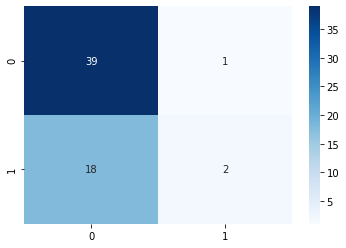

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues')